In [1]:
import os
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [2]:
class PreprocessData():
    """
    Preprocess the data.
    """
    
    def processing_data(self, csv_path):
    
        df = pd.read_csv(csv_path, encoding="ISO-8859-1", index_col='Date Time', parse_dates=['Date Time'], dayfirst=True)

        # Replace errornous data with forward fill
        df.replace(-9999, np.nan, inplace=True)
        df.fillna(method='ffill', inplace=True)

        # Change wind vector from wv, max. wv and wd
        wv = df.pop('wv (m/s)')
        max_wv = df.pop('max. wv (m/s)')

        # Convert to radians.
        wd_rad = df.pop('wd (deg)') * np.pi / 180

        # Calculate the wind x and y components.
        df['Wx'] = wv * np.cos(wd_rad)
        df['Wy'] = wv * np.sin(wd_rad)

        # Calculate the max wind x and y components.
        df['max Wx'] = max_wv*np.cos(wd_rad)
        df['max Wy'] = max_wv*np.sin(wd_rad)

        # Create day/year sin/cos columns as signals for Date Time
        timestamp = df.index.map(datetime.datetime.timestamp)
        day = 24*60*60
        year = (365.2425)*day
        df['Day sin'] = np.sin(timestamp * (2 * np.pi / day))
        df['Day cos'] = np.cos(timestamp * (2 * np.pi / day))
        df['Year sin'] = np.sin(timestamp * (2 * np.pi / year))
        df['Year cos'] = np.cos(timestamp * (2 * np.pi / year))

        # Drop redundant columns
        drop_columns = ['Tpot (K)', 'H2OC (mmol/mol)', 'SWDR (W/m²)']
        df.drop(columns=drop_columns, inplace=True)

        # Use binning for rain column
        rain = df.pop('rain (mm)')
        raining = df.pop('raining (s)')
        df['No rain'] = rain == 0
        df['Light rain'] = (rain < (2.5 / 6)) & (rain > 0)
        df['Moderate/Heavy/Violent rain'] = (rain >= (2.5 / 6))
        
        return df

In [3]:
class WindowGenerator():
    """
    Create a window of consecutive samples of data.
    Use to make a set of predictions which can benefit training.
    
    Attributes:
    -----------
        input_width (int):
            Number of consecutive history data.
        label_width (int):
            Number of future data we want to predict/show.
            If it is None, all the future data from 'shift' is shown.
        shift (int):
            Number of consecutive future data.
        train_df (pd.DataFrame):
            Training data.
        val_df (pd.DataFrame):
            Validation data.
        test_df (pd.DataFrame):
            Test data.
        label_columns (list of str, pd.Index or None):
            List of columns that we want to predict.
    """
    
    def __init__(self, input_width, shift, 
                 train_df, test_df, val_df,
                 table_columns,
                 label_width=None,
                 label_columns=None):
        # Store the raw data
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        # Work out the label column indices
        self.table_columns = table_columns
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                          enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(table_columns)}
        
        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        # slice(a, b) function will return a slice object.
        # arr[slice(a, b)] = arr[a:b]
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    
    def split_window(self, features):
        """Convert list of consecutive inputs into a window of inputs and a window of labels (output)."""
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                    [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                    axis=-1
            )
        
        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.`
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
        """
        Visualize how the window is organized.
        Can also be used to visualize prediction.
        """
        inputs, labels = self.example
        plt.figure(figsize=(12, (8/3)*max_subplots))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [*10 minutes]')
        
    def make_dataset(self, data):
        """Convert the DataFrame into a tf.data.Dataset."""
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,
        )

        ds = ds.map(self.split_window)
        
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.test))
            # And cache it for next time
            self._example = result
        return result

In [4]:
class Standardization():
    
    def fit(self, X):
        self.mean = X.mean()
        self.std = X.std()
        
    def transform(self, X):
        return (X - self.mean) / self.std
    
    def inverse_transform(self, X, label_columns=None):
        if label_columns is None:
            label_columns = self.mean.columns
        return X * self.std[label_columns].to_numpy() + self.mean[label_columns].to_numpy()
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

In [5]:
class WeatherPrediction():
    """
    The pipeline of weather prediction.
    
    Attributes:
    ----------
        model: str or tf.keras.Model
            Model selection to use.
        n_history_data: int
            Number of history data's rows.
        n_predict_data: int
            When multi_time_step is set to True, this represents number of predict data's rows,
            counting from the last timestamp of history data. Otherwise, it is the offset of
            how far from the last timestamp you want to predict (10 mins * n_predict_data).
        multi_time_step: bool
            Predict multi-time-step or single-time-step.
        label_columns: list<str>
            List of columns that we want to predict.
        verbose:
            If True, the training phase will provide error (by stat and graph), and model summary.
        history:
            Store the best model after training.
    """
    
    def __init__(self, model, n_history_data=18, n_predict_data=6, 
                 multi_time_step=False, label_columns=['T (degC)'],
                 verbose=False):
        self.model = model
        self.input_width = n_history_data
        self.label_width = n_predict_data
        self.multi_time_step = multi_time_step
        self.label_columns = label_columns
        self.verbose = verbose
        self.history = None
        
    def fit(self, X):
        """
        Fit data into selected model with created customization.
        
        Args:
        -----
            X: DataFrame
                Training data
        """
        
        if isinstance(self.model, str):
            self.model = self.select_model(self.model)
        
        # Split the dataset into training set, validation set and test set
        train_df, val_df, test_df = self.train_test_split(X)
        
        # Standardize the data
        self.standard = Standardization()
        train_df = self.standard.fit_transform(train_df)
        val_df = self.standard.transform(val_df)
        test_df = self.standard.transform(test_df)
        
        # Create window
        self.window = WindowGenerator(input_width=self.input_width,
                                      label_width=(self.label_width if self.multi_time_step else 1),
                                      shift=self.label_width,
                                      label_columns=self.label_columns,
                                      table_columns=X.columns,
                                      train_df=train_df, test_df=test_df, val_df=val_df)
        
        # Train the model
        if self.verbose:
            self.history = self.training_package()
        else:
            self.history = self.compile_and_fit()
            
    def predict(self, X, export_csv=False, dest_file='result.csv'):
        """
        Predict future data from the given data.
        
        Args:
        -----
            X: DataFrame
                Given data. Although we can assign it to the last trained data,
                but it is not training data.
            export_csv: bool
                If True, the pipeline will export a `.csv` file to the project
                folder.
            dest_file: str
                The filename of the exporting `.csv` file.
        """
        
        if self.history is None:
            raise Exception('Model has not been trained, use fit() to train the model first.')
        if X.shape[0] < self.input_width:
            raise Exception(f'The provided dataset must have number of records greater or equal to {self.input_width}')
        
        # Standardize the data
        X_new = self.standard.transform(X)
        X_new = X_new[-self.input_width:]
        
        # Change into tensor dataset and make prediction
        ds = tf.constant([np.array(X_new)])
        prediction = self.model(ds)
        
        # Inverse transform to get the real value
        X_pred = self.standard.inverse_transform(prediction.numpy()[0, :, :], self.label_columns)

        if export_csv:
            self.export_csv(X_new, X_pred, dest_file=dest_file)
            
        return X_pred
    
    def export_csv(self, X, X_pred, dest_file):
        
        last = X.index[-1]
        indices = []
        
        if self.multi_time_step:
            for i in range(self.label_width):
                indices.append(last + datetime.timedelta(minutes=10*i))
        else:
            indices = [last + datetime.timedelta(minutes=10*self.label_width)]
        
        df_pred = pd.DataFrame(X_pred, columns=self.label_columns, index=indices)
        df_pred.to_csv(os.path.join('', dest_file), index_label='Date Time')
    
    def compile_and_fit(self, patience=3, path_checkpoint='model_checkpoint.h5', opt='Adam'):
        
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                          patience=patience,
                                                          mode='min')

        model_checkpoint = tf.keras.callbacks.ModelCheckpoint(monitor="val_loss", 
                                                              filepath=path_checkpoint,
                                                              verbose=0,
                                                              save_weights_only=True,
                                                              save_best_only=True)

        self.model.compile(loss=tf.losses.MeanSquaredError(),
                           optimizer=opt)

        history = self.model.fit(self.window.train, epochs=20,
                                verbose=0,
                                validation_data = self.window.val,
                                callbacks=[early_stopping, model_checkpoint])

        return history
    
    def visualize_loss(self, history, title="Training and Validation Loss"):
        loss = history.history["loss"]
        val_loss = history.history["val_loss"]
        epochs = range(len(loss))
        plt.figure(figsize=(6,6))
        plt.plot(epochs, loss, "b", label="Training loss")
        plt.plot(epochs, val_loss, "r", label="Validation loss")
        plt.title(title)
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()
        
    def training_package(self):
        print('Training model')
        history = self.compile_and_fit()

        print('Model summary')
        print(self.model.summary())

        print('Visualize loss')
        self.visualize_loss(history)

        print('Prediction result samples')
        for plot_col in self.label_columns:
            self.window.plot(model=self.model, plot_col=plot_col)
        
        print('Validation error')
        self.val_error = self.model.evaluate(self.window.val)
        print('Test error')
        self.test_error = self.model.evaluate(self.window.test)
        
        return history
    
    def train_test_split(self, X, train_size=0.7, val_size=0.2):
        n = len(X)
        
        if train_size + val_size > 1.0:
            raise ValueError('train_size + val_size must be smaller than 1.0')
            
        train_df = X[0 : int(n * train_size)]
        val_df = X[int(n * train_size) : int(n * (train_size + val_size))]
        test_df = X[int(n * (train_size + val_size)):]

        return train_df, val_df, test_df
        
    
    def standardize(self, train_df, val_df=None, test_df=None):
        self.train_mean = train_df.mean()
        self.train_std = train_df.std()

        train_df = (train_df - self.train_mean) / self.train_std
        if val_df is not None:
            val_df = (val_df - self.train_mean) / self.train_std
        if test_df is not None:
            test_df = (test_df - self.train_mean) / self.train_std
        
        return train_df, val_df, test_df if val_df is not None else train_df
    
    def select_model(self, model):
        n_features = len(self.label_columns)
        if not self.multi_time_step:
            if model == 'linear':
                return tf.keras.Sequential([
                                tf.keras.layers.Flatten(),
                                tf.keras.layers.Dense(units=n_features, 
                                                      kernel_regularizer=tf.keras.regularizers.L1(0.01)),
                                tf.keras.layers.Reshape([1, n_features]),
                            ])
            if model == 'mlp':
                return tf.keras.Sequential([
                                tf.keras.layers.Flatten(),
                                tf.keras.layers.Dense(units=8, activation='relu'),
                                tf.keras.layers.Dense(units=8, activation='relu'),
                                tf.keras.layers.Dense(units=n_features),
                                tf.keras.layers.Reshape([1, n_features]),
                            ])
            if model == 'lstm':
                return tf.keras.Sequential([
                                tf.keras.layers.LSTM(8, return_sequences=False),
                                tf.keras.layers.Dense(n_features),
                                tf.keras.layers.Reshape([1, n_features])
                            ])
            else:
                raise Exception('You have assign a wrong model or an incompatible one.')
        else:
            if model == 'lstm':
                return tf.keras.Sequential([
                                tf.keras.layers.LSTM(8, return_sequences=False),
                                tf.keras.layers.Dense(self.label_width * n_features),
                                tf.keras.layers.Reshape([self.label_width, n_features])
                            ])
            else:
                raise Exception('You have assign a wrong model or an incompatible one.')

In [6]:
# Test 0: PARAMETERS

# File path
csv_path_train = "mpi_roof_2020a.csv"
csv_path_test = "mpi_roof_2020b.csv"

predict_params = {
    'model': 'linear',
    'n_history_data': 3*6,
    'n_predict_data': 1*6,
    'multi_time_step': False,
    'label_columns': ['T (degC)'],
    'verbose': True,
}

dest_file = 'pred_2020b_linear.csv'

Training model
Model summary
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 432)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 433       
_________________________________________________________________
reshape (Reshape)            (None, 1, 1)              0         
Total params: 433
Trainable params: 433
Non-trainable params: 0
_________________________________________________________________
None
Visualize loss


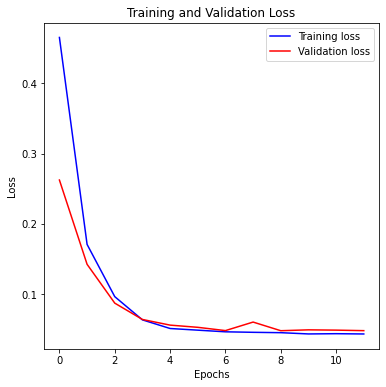

Prediction result samples
Validation error
163/163 [==============================] - 0s 1ms/step - loss: 0.0479
Test error
82/82 [==============================] - 0s 1ms/step - loss: 0.0741


array([[1.81057804]])

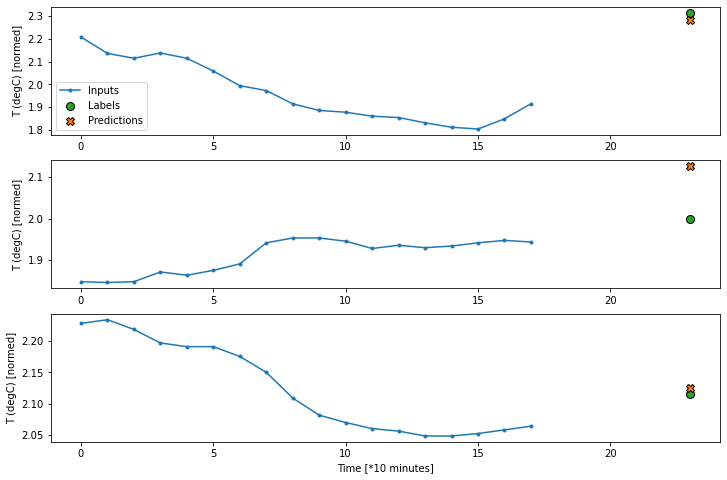

In [7]:
prep = PreprocessData()
df_train = prep.processing_data(csv_path_train)
df_test = prep.processing_data(csv_path_test)
weather_prediction = WeatherPrediction(**predict_params)
weather_prediction.fit(df_train)
weather_prediction.predict(df_test, export_csv=True, dest_file=dest_file)

In [8]:
# Test 1: PARAMETERS

# File path
csv_path_train = "mpi_roof_2020a.csv"
csv_path_test = "mpi_roof_2020b.csv"

predict_params = {
    'model': 'mlp',
    'n_history_data': 3*6,
    'n_predict_data': 1*6,
    'multi_time_step': False,
    'label_columns': ['p (mbar)'],
    'verbose': True,
}

dest_file = 'pred_2020b_mlp.csv'

Training model
Model summary
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 432)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 3464      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
_________________________________________________________________
reshape_1 (Reshape)          (None, 1, 1)              0         
Total params: 3,545
Trainable params: 3,545
Non-trainable params: 0
_________________________________________________________________
None
Visualize loss


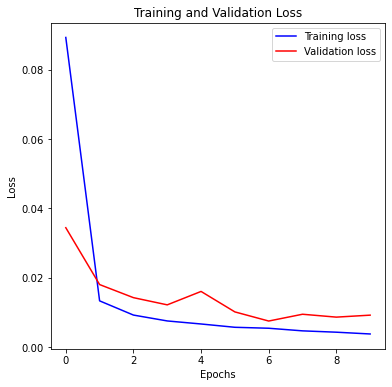

Prediction result samples
Validation error
163/163 [==============================] - 0s 1ms/step - loss: 0.0092
Test error
82/82 [==============================] - 0s 1ms/step - loss: 0.0530


array([[977.88684961]])

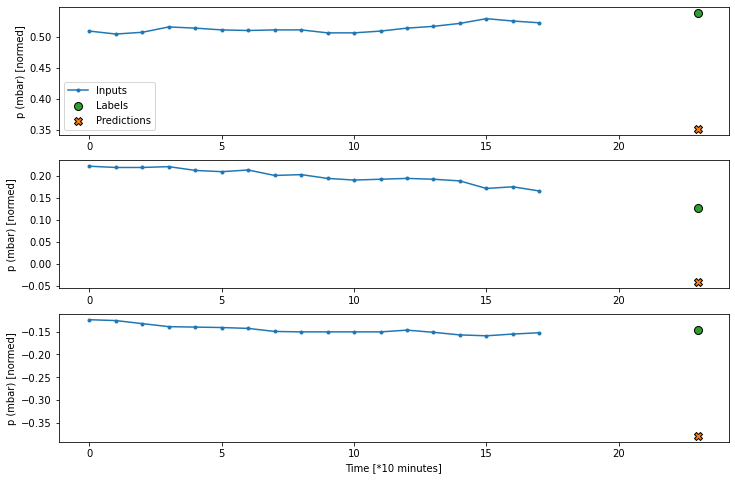

In [9]:
prep = PreprocessData()
df_train = prep.processing_data(csv_path_train)
df_test = prep.processing_data(csv_path_test)
weather_prediction = WeatherPrediction(**predict_params)
weather_prediction.fit(df_train)
weather_prediction.predict(df_test, export_csv=True, dest_file=dest_file)

In [10]:
# Test 2: PARAMETERS

# File path
csv_path_train = "mpi_roof_2020a.csv"
csv_path_test = "mpi_roof_2020b.csv"

predict_params = {
    'model': 'lstm',
    'n_history_data': 3*6,
    'n_predict_data': 1*6,
    'multi_time_step': True,
    'label_columns': ['T (degC)', 'p (mbar)'],
    'verbose': True,
}

dest_file = 'pred_2020b_lstm_short.csv'

Training model
Model summary
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 8)                 1056      
_________________________________________________________________
dense_4 (Dense)              (None, 12)                108       
_________________________________________________________________
reshape_2 (Reshape)          (None, 6, 2)              0         
Total params: 1,164
Trainable params: 1,164
Non-trainable params: 0
_________________________________________________________________
None
Visualize loss


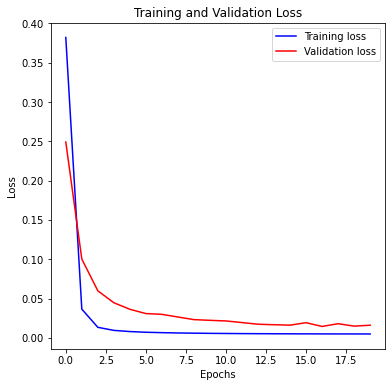

Prediction result samples
Validation error
163/163 [==============================] - 0s 2ms/step - loss: 0.0161
Test error
82/82 [==============================] - 0s 3ms/step - loss: 0.0595


array([[  2.00088946, 978.43574182],
       [  1.96653627, 978.45947973],
       [  1.92174136, 978.49474123],
       [  1.89569406, 978.51839046],
       [  1.77994882, 978.56068154],
       [  1.78758667, 978.61900773]])

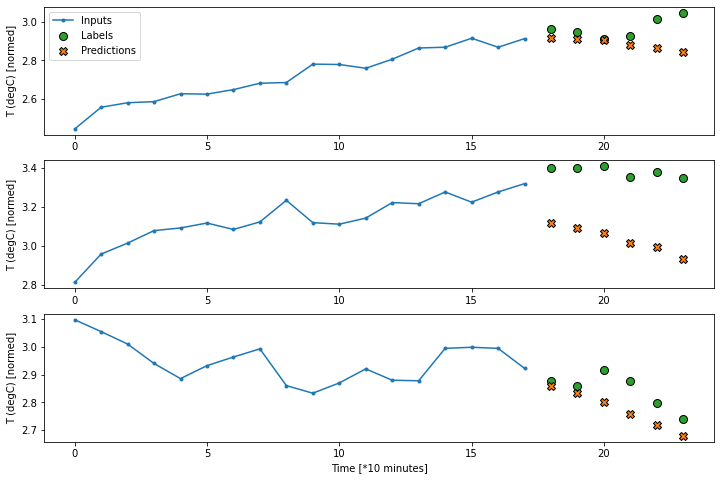

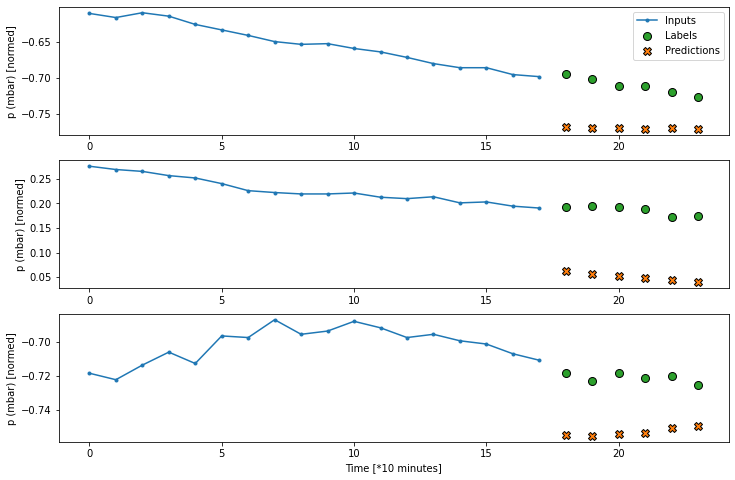

In [11]:
prep = PreprocessData()
df_train = prep.processing_data(csv_path_train)
df_test = prep.processing_data(csv_path_test)
weather_prediction = WeatherPrediction(**predict_params)
weather_prediction.fit(df_train)
weather_prediction.predict(df_test, export_csv=True, dest_file=dest_file)

In [12]:
# Test 3: PARAMETERS

# File path
csv_path_train = "mpi_roof_2020a.csv"
csv_path_test = "mpi_roof_2020b.csv"

predict_params = {
    'model': 'lstm',
    'n_history_data': 24*6,
    'n_predict_data': 12*6,
    'multi_time_step': True,
    'label_columns': ['T (degC)', 'p (mbar)', 'sh (g/kg)'],
    'verbose': False,
}

dest_file = 'pred_2020b_lstm_long.csv'

In [13]:
prep = PreprocessData()
df_train = prep.processing_data(csv_path_train)
df_test = prep.processing_data(csv_path_test)
weather_prediction = WeatherPrediction(**predict_params)
weather_prediction.fit(df_train)
weather_prediction.predict(df_test, export_csv=True, dest_file=dest_file)

array([[  3.26246369, 979.77808354,   3.39802165],
       [  3.19577733, 979.77973226,   3.39719927],
       [  3.12545093, 979.78651952,   3.3975265 ],
       [  3.05835812, 979.79619454,   3.39578212],
       [  2.97841456, 979.80623928,   3.39253498],
       [  2.89614711, 979.8194266 ,   3.39094806],
       [  2.81002429, 979.83497209,   3.38928666],
       [  2.72499649, 979.84851787,   3.38882324],
       [  2.640845  , 979.85586594,   3.39046787],
       [  2.56792487, 979.8723632 ,   3.39230507],
       [  2.49282603, 979.89479462,   3.3948523 ],
       [  2.42712473, 979.91414967,   3.39643202],
       [  2.3623947 , 979.92889952,   3.39869794],
       [  2.29842583, 979.94272634,   3.40015596],
       [  2.23145308, 979.96830408,   3.40175979],
       [  2.17235435, 979.98908802,   3.40584635],
       [  2.13022363, 980.01050898,   3.41033178],
       [  2.08876707, 980.0310531 ,   3.41452925],
       [  2.04690619, 980.05286375,   3.41941458],
       [  2.00756952, 980.07517